In [847]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/quadrotor_quat/Project.toml`


In [848]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using Printf

In [849]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [850]:
#Quadrotor parameters
m = 0.03
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
thrustToTorque = 0.005964552
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8


h = 1/50 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
nx = Nx̃
nu = Nu
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [851]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = Q*v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
  
  ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [852]:
#Goal state
uhover = (0.5)*ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 1.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [853]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u 
end

discrete_dynamics (generic function with 1 method)

In [854]:
# Adaptive step in MPC horizon: use normal dt and model in the first specified 
# `adaptive_step` steps and after that use the stretch mode (larger dt and model)
h = 1/1 #25 Hz stretch interval dynamics
#Linearize dynamics about hover
As = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
Bs = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ãs = Array(E(qg)'*As*E(qg))
B̃s = Array(E(qg)'*Bs);
function discrete_dynamics_stretch(params,x,u,k)
  Ãs*x + B̃s*u
end

discrete_dynamics_stretch (generic function with 1 method)

In [871]:
h = 1/50 #50 Hz normal dynamics
step_ratio = Int(50/1)
display(Ãs)
display(Ã)

12×12 Matrix{Float64}:
 1.0  0.0  0.0    0.0    9.81  0.0  1.0  0.0  0.0   0.0    1.635  0.0
 0.0  1.0  0.0   -9.81   0.0   0.0  0.0  1.0  0.0  -1.635  0.0    0.0
 0.0  0.0  1.0    0.0    0.0   0.0  0.0  0.0  1.0   0.0    0.0    0.0
 0.0  0.0  0.0    1.0    0.0   0.0  0.0  0.0  0.0   0.5    0.0    0.0
 0.0  0.0  0.0    0.0    1.0   0.0  0.0  0.0  0.0   0.0    0.5    0.0
 0.0  0.0  0.0    0.0    0.0   1.0  0.0  0.0  0.0   0.0    0.0    0.5
 0.0  0.0  0.0    0.0   19.62  0.0  1.0  0.0  0.0   0.0    4.905  0.0
 0.0  0.0  0.0  -19.62   0.0   0.0  0.0  1.0  0.0  -4.905  0.0    0.0
 0.0  0.0  0.0    0.0    0.0   0.0  0.0  0.0  1.0   0.0    0.0    0.0
 0.0  0.0  0.0    0.0    0.0   0.0  0.0  0.0  0.0   1.0    0.0    0.0
 0.0  0.0  0.0    0.0    0.0   0.0  0.0  0.0  0.0   0.0    1.0    0.0
 0.0  0.0  0.0    0.0    0.0   0.0  0.0  0.0  0.0   0.0    0.0    1.0

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0       0.003924  0.0  …  0.0    0.0       1.308e-5  0.0
 0.0  1.0  0.0  -0.003924  0.0       0.0     0.0   -1.308e-5  0.0       0.0
 0.0  0.0  1.0   0.0       0.0       0.0     0.02   0.0       0.0       0.0
 0.0  0.0  0.0   1.0       0.0       0.0     0.0    0.01      0.0       0.0
 0.0  0.0  0.0   0.0       1.0       0.0     0.0    0.0       0.01      0.0
 0.0  0.0  0.0   0.0       0.0       1.0  …  0.0    0.0       0.0       0.01
 0.0  0.0  0.0   0.0       0.3924    0.0     0.0    0.0       0.001962  0.0
 0.0  0.0  0.0  -0.3924    0.0       0.0     0.0   -0.001962  0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     1.0    0.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    1.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0  …  0.0    0.0       1.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    0.0       0.0       1.0

In [1333]:
# IHLQR terminal cost
P = [zeros(nx,nx) for i = 1:200]   # cost to go quadratic term
p = [zeros(nx) for i = 1:200]      # cost to go linear term
d = [zeros(nu) for i = 1:200-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:200-1] # feedback gain

# Cost weights
Q = Array(Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 1; 1; 1.]));
R = Array(1*I(Nu));
Qf = Q

# PENALTY - important!!
ρ = 0.1
R̃ = R + ρ*I  # use regularized R

cache = (
    Kinf = zeros(nu,nx),
    Pinf = zeros(nx,nx),
    Kinf2 = zeros(nu,nx),
    Pinf2 = zeros(nx,nx),
    Quu_inv = zeros(nu,nu),
    Quu_inv2 = zeros(nu,nu),
    AmBKt = zeros(nx,nx), 
    AmBKt2 = zeros(nx,nx), #(Ã - B̃*K[1])',
    coeff_d2p = zeros(nx,nu), 
    coeff_d2p2 = zeros(nx,nu), 
)

P[200] = Q
for k = (200-1):-1:1
    K[k] .= (R + B̃s'*P[k+1]*B̃s)\(B̃s'*P[k+1]*Ãs)
    P[k] .= Q + Ãs'*P[k+1]*(Ãs - B̃s*K[k])
end
cache.Kinf2 .= K[1]
cache.Pinf2 .= P[1]
cache.AmBKt2 .= (Ãs - B̃s*K[1])'
for k = (200-1):-1:1
    K[k] .= (R + B̃'*P[k+1]*B̃)\(B̃'*P[k+1]*Ã)
    P[k] .= Q + Ã'*P[k+1]*(Ã - B̃*K[k])
end
cache.Kinf .= K[1]
cache.Pinf .= P[1]
cache.AmBKt .= (Ã - B̃*K[1])'

cache.Quu_inv .= (R̃ + B̃'*cache.Pinf*B̃)\I
cache.Quu_inv2 .= (R̃ + B̃s'*cache.Pinf2*B̃s)\I

cache.coeff_d2p = cache.Kinf'*R - cache.AmBKt*cache.Pinf*B̃
cache.coeff_d2p2 = cache.Kinf2'*R - cache.AmBKt2*cache.Pinf2*B̃s

4×4 Matrix{Float64}:
 0.000427478  0.00034175   0.000429429  0.000340965
 0.00034175   0.000428666  0.000339758  0.000429448
 0.000429429  0.000339758  0.000431503  0.000338933
 0.000340965  0.000429448  0.000338933  0.000430276

In [1327]:
#Feedback tracking controller
include("tinyMPC-ADMM.jl")
N = 5
dt = h
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)


#Create trajectory to follow
Xref = [[0;0;1;1;zeros(9)] for i = 1:Nt]
Δx̃ref = [zeros(nx) for i = 1:Nt]
ΔUref = [zeros(nu) for i = 1:Nt-1]

# Number-eight
# Xref = [[1*cos(t)*sin(t);1*cos(t);1;1;zeros(9)] for t = range(0, 2*pi + 1*pi/4, length = Nt)]  

## Triangle
p0 = [0; 0; 1.0]; p1 = [3; 4; 1.]; p2 = [0; 8; 1.]; p3 = [0; -2; 1.0]
range1 = collect(LinRange(p0, p1, round(Int,(Nt)/3)))
range2 = collect(LinRange(p1, p2, round(Int,(Nt)/3)))
range3 = collect(LinRange(p2, p3, round(Int,(Nt)/3)+1))
range123 = [range1; range2; range3]
for k = 1:Nt
    Xref[k][1:3] .= range123[k]
end


for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end

u_min = -1*uhover
u_max =  1*uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.2
x_max = 100*ones(nx)
x_max[3] = 0.2

ncx = 2*nx*1
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem
 
# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
Z = [zeros(nu) for i = 1:N-1]
Znew = [zeros(nu) for i = 1:N-1]
Y = [zeros(nu) for i = 1:N-1]

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    N = N, Q = Q, R = R, Qf = Qf,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = ΔUref, dt = dt, cache = cache
);

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
qq = [zeros(nx) for i = 1:N]
r = [zeros(nu) for i = 1:N-1]

verbose = 0
adaptive_step = 0
function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    X[1] .= Δx̃
    # u = mpc_JuMP(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=true)
    # u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-2,max_iters=10,max_inner_iters=5,verbose=false,ρ=1e0,ρ_max=1e6, ϕ=10.0, adaptive_step=1)
    u, iter = solve_admm!(params,qq,R̃,r,P,p,K,d,X,U,Z,Znew,Y; ρ=ρ,abs_tol=1e-2,max_iter=200,adaptive_step=adaptive_step)
    return u + uhover
end

#ASK: Do I need to stretch the reference?
function update_reference(params, k)
    Uref_ = 1*ΔUref[k:N+k-2]
    Xref_ = 1*Δx̃ref[k:N+k-1]

    # for i = 3:N-1
    #     Uref_[i] .= ΔUref[k+1+(i-2)*step_ratio]
    #     Xref_[i] .= Δx̃ref[k+1+(i-2)*step_ratio]
    # end
    # Xref_[N] .= Δx̃ref[k+1+(N-2)*step_ratio]
    
    params1 = (; params..., Uref = Uref_, Xref = Xref_)  # update ref
    return params1
end


update_reference (generic function with 1 method)

In [1328]:
# Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+randn(3)/3; L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
xhist[1] .= Xref[1]
# xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*0.2
backward_pass!(Q,qq,R̃,r,P,p,K,d,params,adaptive_step)
Nsim = Nt - 50 - 1
for k = 1:Nsim
# for k = 1:3
    params1 = update_reference(params, k)
    # display(params1.Xref)
    # display(xhist[k])
    shift_fill(U)
    @time uhist[k] = controller_mpc(params1, xhist[k], k)
    # uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k]) 
end

  0.490109 seconds (728.18 k allocations: 48.967 MiB, 6.81% gc time, 99.91% compilation time)
  0.000120 seconds (394 allocations: 60.938 KiB)
  0.000100 seconds (394 allocations: 60.938 KiB)
  0.000086 seconds (394 allocations: 60.938 KiB)
  0.000082 seconds (394 allocations: 60.938 KiB)
  0.000084 seconds (394 allocations: 60.938 KiB)
  0.000082 seconds (394 allocations: 60.938 KiB)
  0.000087 seconds (394 allocations: 60.938 KiB)
  0.000084 seconds (394 allocations: 60.938 KiB)
  0.000088 seconds (394 allocations: 60.938 KiB)
  0.000089 seconds (394 allocations: 60.938 KiB)
  0.000088 seconds (394 allocations: 60.938 KiB)
  0.000087 seconds (394 allocations: 60.938 KiB)
  0.000128 seconds (394 allocations: 60.938 KiB)
  0.000080 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000053 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000065 seconds (394 allocations: 60.938 KiB)
  0.000120 seconds (394 

  0.000088 seconds (394 allocations: 60.938 KiB)
  0.000059 seconds (394 allocations: 60.938 KiB)
  0.000054 seconds (394 allocations: 60.938 KiB)
  0.000110 seconds (394 allocations: 60.938 KiB)
  0.000054 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000050 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000050 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (

  0.000056 seconds (394 allocations: 60.938 KiB)
  0.000053 seconds (394 allocations: 60.938 KiB)
  0.000053 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000057 seconds (394 allocations: 60.938 KiB)
  0.000053 seconds (394 allocations: 60.938 KiB)
  0.000053 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000050 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000050 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000052 seconds (394 allocations: 60.938 KiB)
  0.000051 seconds (394 allocations: 60.938 KiB)
  0.000065 seconds (

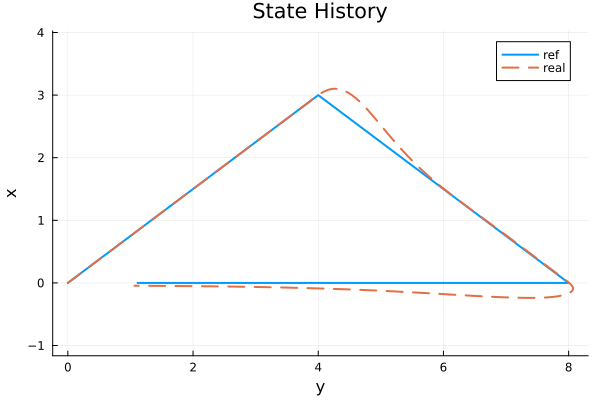

In [1329]:
Xsim_m = mat_from_vec(Xref[1:Nsim])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:Nsim])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

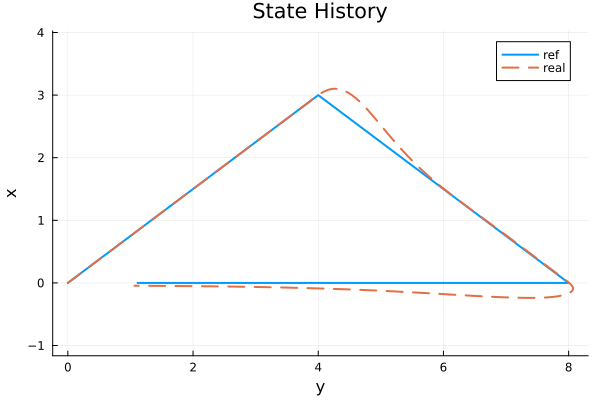

In [1330]:
Xsim_m = mat_from_vec(Xref[1:1:Nsim])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:1:Nsim])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

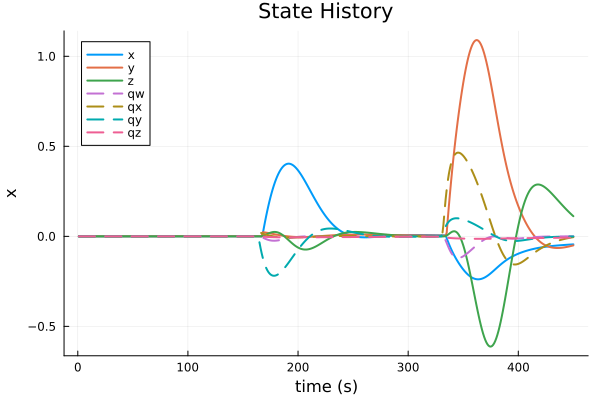

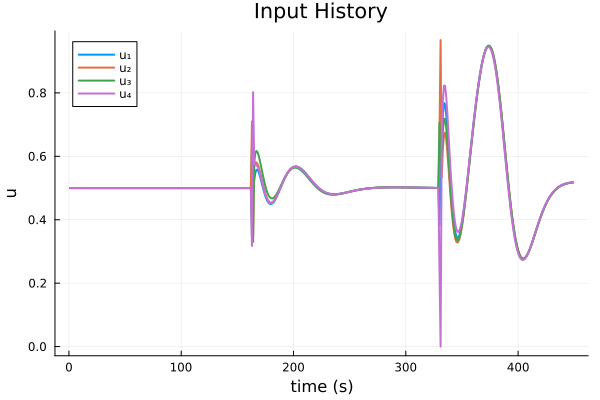

In [1331]:
Xsim_m = mat_from_vec(xhist[1:Nsim]-Xref[1:Nsim])   
Usim_m = mat_from_vec(uhist[1:Nsim-1])   
display(plot(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

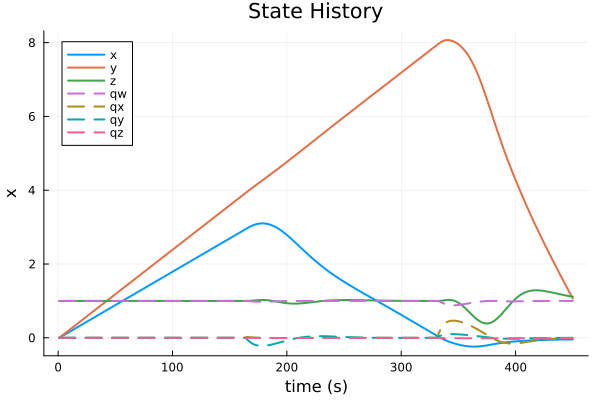

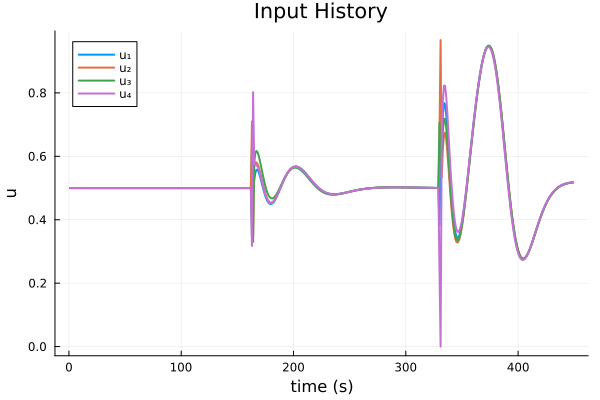

In [1332]:
Xsim_m = mat_from_vec(xhist[1:Nsim])   
Usim_m = mat_from_vec(uhist[1:Nsim-1])   
display(plot(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))